In [520]:
# подгружаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, shapiro, ttest_ind, bartlett
import requests
from urllib.parse import urlencode

%matplotlib inline
sns.set()

### Загрузка и первичный осмотр данных

Загрузим датасет, посмотрим на имеющиеся данные и типы данных

In [504]:
# парсим данные
public_key = 'https://disk.yandex.ru/d/txn7q-CE2zSaPg'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
dating_app = pd.read_csv(download_url, sep=',')
dating_app.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [505]:
# Для удобства присвоим имена значениям категориальных переменных
dating_app['group'] = dating_app['group'].apply(lambda x: 'old algorithm' if x == 0 else 'new algorithm')
dating_app['is_match'] = dating_app['is_match'].apply(lambda x: 'no match' if x == 0 else 'match')

In [506]:
dating_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id_1  14514 non-null  int64 
 1   user_id_2  14514 non-null  int64 
 2   group      14514 non-null  object
 3   is_match   14514 non-null  object
dtypes: int64(2), object(2)
memory usage: 453.7+ KB


Данные во всех колонках целые, типы данных не нуждаются в изменении. 

In [507]:
# Посмотрим на размеры выборок для каждой группы
dating_app.groupby('group', as_index=False).agg({'user_id_1': 'nunique'})

,group,user_id_1
0,new algorithm,499
1,old algorithm,501


У нас практически равные выборки для двух групп

In [508]:
# Посмотрим на описание переменных
dating_app.describe(include=object)

,group,is_match
count,14514,14514
unique,2,2
top,new algorithm,no match
freq,9722,9671


### Обработка пропущенных значений

Посмотрим, есть ли пропущенные значения в датасете и при необходимости уберем/заменим их

In [509]:
# Смотрим пропущенные значения
dating_app.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

Пропущенные значения отсуствуют.

### Анализ распределения числовых переменных

Построим гистограммы и диаграммы для лучшего понимания данных. Явных числовых переменных у нас нет, но мы можем ее создать. Выбор у нас невелик, в данном случае интересно посмотреть на активность пользователей в разных группах. Данная метрика может определять качество сервиса. Так как активность пользователей свидетельствует о том, насколько сервис интересен юзерам, а это в свою очередь говорит о качестве. 

Создадим две переменные, где будет хранится информация об активности пользователей в приложении, отдельно для старой и новой версии. И посмотрим нормальность распределения с помощью графиков.


In [510]:
# Находим частоту использования приложения для каждой версии
new_alg_count_use_app = dating_app.loc[dating_app.group == 'new algorithm'].groupby(['user_id_1']).agg({'group': 'count'})
old_alg_count_use_app = dating_app.loc[dating_app.group == 'old algorithm'].groupby(['user_id_1']).agg({'group': 'count'})

Посмотрим, каким каким алгоритмом пользовались чаще

In [511]:
# Смотрим процентное соотношение активности в группах
dating_app.group.value_counts(normalize=True).mul(100)

new algorithm    66.983602
old algorithm    33.016398
Name: group, dtype: float64

Новый алгоритм в два разе чаще использовался, чем старый.

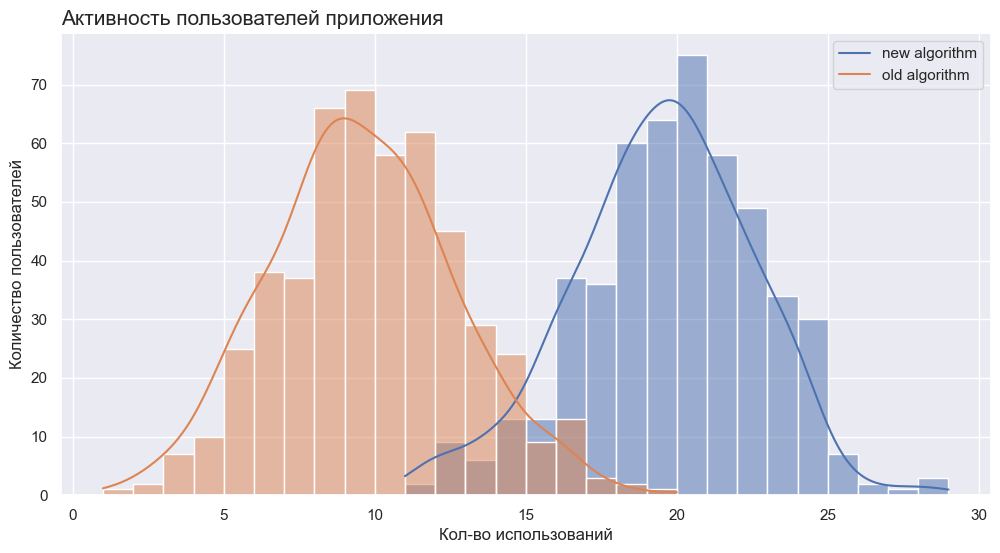

In [512]:
# Строим гистограммы
plt.figure(figsize=(12, 6))
sns.histplot(data=new_alg_count_use_app, x="group", kde=True)
sns.histplot(data=old_alg_count_use_app, x="group", kde=True)
plt.legend(["new algorithm", "old algorithm"])
plt.xlabel('Кол-во использований')
plt.ylabel('Количество пользователей')
plt.title('Активность пользователей приложения', fontsize= 15 , loc='left')
plt.show()

Гистограммы имеют колокообразную форму, однако по ним нельзя сказать, что расрпеделения нормальны. Убедимся в нормальности распределения статистически - проведем тест Шапиро-Уилка. 

In [513]:
# Тест Шапиро-Уилка для нового алгоритма
shapiro(new_alg_count_use_app)

ShapiroResult(statistic=0.9839300513267517, pvalue=2.542138463468291e-05)

In [514]:
# Тест Шапиро-Уилка для старого алгоритма
shapiro(old_alg_count_use_app)

ShapiroResult(statistic=0.9884840846061707, pvalue=0.0005569988279603422)

p.value в обоих группах значительно меньше 0.5, поэтому мы отвергаем нулевую гипотезу и будем считать, что наши распределения не являются нормальными.

### Анализ категориальных переменных

У нас есть две явных категориальных переменных - это группы и мэрч. Посмотрим на их количественные показатели и взаимосвязи.

Посмотрим, влияет ли группа на мэтч

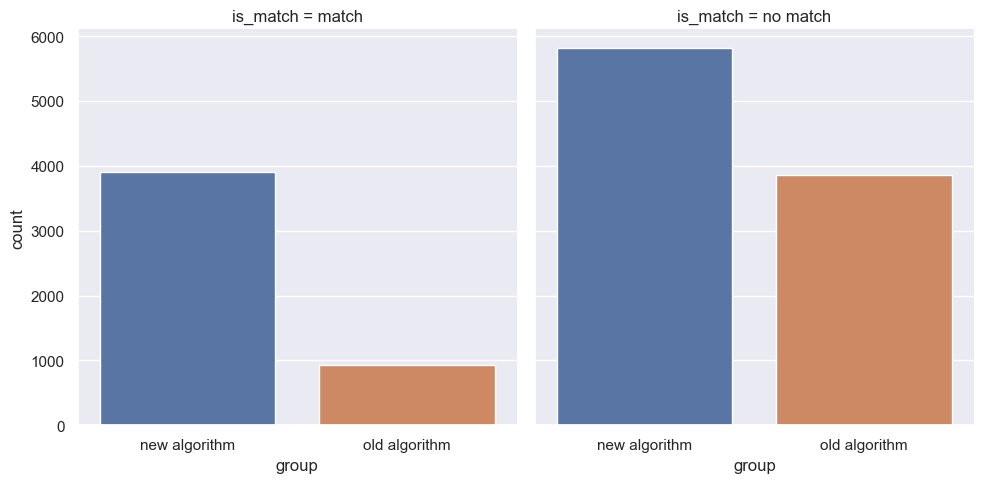

In [515]:
# строим график влияния группы на мэтчи
sns.catplot(
    dating_app, kind="count",
    x="group", col="is_match"
)

На графиках можно заметить, что с новым алгоритмом у нас match и no match выросли, по сравнению со старым алгоритмом. Посмотрим на процентное соотношение.

In [516]:
# Создаем датафрейм с процентным соотношением мэтчей в группах
dating_app_perc = (dating_app.groupby('group')['is_match']
        .value_counts(normalize = True).round(2)
        .to_frame('perc').reset_index()
          )

In [517]:
dating_app_perc

,group,is_match,perc
0,new algorithm,no match,0.60
1,new algorithm,match,0.40
2,old algorithm,no match,0.81
3,old algorithm,match,0.19


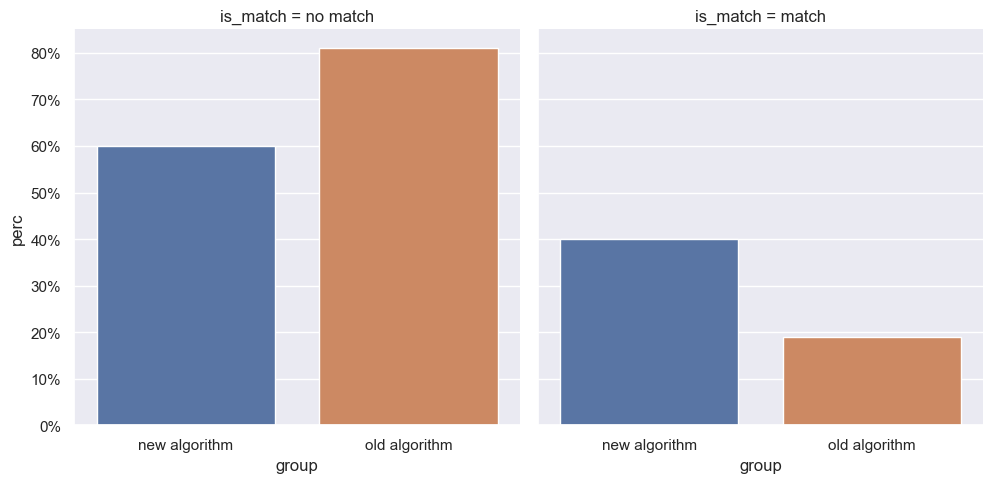

In [518]:
# Рисуем гистограмму
from matplotlib.ticker import PercentFormatter
p = sns.catplot(dating_app_perc, x='group', y='perc', col='is_match', kind='bar')
for ax in p.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

Если рассматривать процентное соотношение, то новый алгоритм показывает лучшие показатели - match вырос, а no_match снизился. Мы можем рассматривать количество мэтчей как метрику, которая определяет качество сервиса. Так как главная задача сервиса - это знакомить людей, а мэтч, в данном случае, ключевой показатель выполнения данной задачи. То есть, чем больше мэтчей было, тем больше людей друг другу понравились и, возможно, смогли познакомиться.  

### Выявление выбросов и аномалий


Выбросы и аномалии имеет смысл посмотреть только в активности пользователей. Для этого используется визуализация, например, ящик с усами (box plot).

<Axes: >

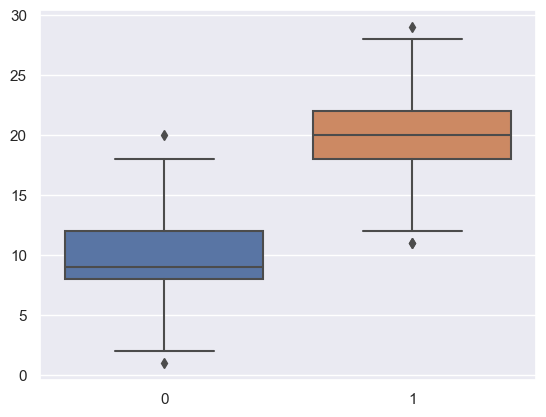

In [519]:
sns.boxplot([old_alg_count_use_app, new_alg_count_use_app])

Можно заметить, что у каждой группы есть по два выброса с двух сторон, однако они чуть выше/ниже максимальных и минимальных значений, поэтому убирать мы их не будем. Разброс в группах небольшой, усы равной длины, у группы со старым алгоритмом наблюдается левая ассиметрия.

### Исследование корреляций между переменными


Данное исследование решил не проводить, так как полученных данных мне достаточно для определения ключевых метрик и критериев их оценки. К тому же у нас мало числовых переменных.

### Вывод по EDA

У нас две группы практически одинаковых размеров. Пустые значения в данных отсутствуют. Активных пользователей количественно больше в группе с новым алгоритмом, при этом распределение в двух группах ненормальные. Предварительный анализ категориальных переменных показал, что с использование нового алгоритма выросло количество match и снизилось кол-во no match. Есть незначительные аномалии и выбросы в данных, которые не должны повлиять на результаты тестов.

Мы можем выделить две ключевые метрики, которые помогут нам оценить качество сервиса при статистическом сравнении - активность пользователей и количество мэтчей. Активность пользователей говорит об интересе к сервису, а интерес своеборазный показатель качества. А Мэтч послужит ключевым показателем выполнения главной задачи сервиса - знакомства людей. То есть, чем больше мэтчей было, тем больше людей друг другу понравились и, возможно, смогли познакомиться (сервис выполняет свою главную работу, а значит работает качественно). Для сравнения активность пользователей будем использовать t-test стьюдента, а для сравнения количества мэтчей будем использовать критерий независимости хи-квадрат. 


### Проверяем гипотезу разницы средней активных пользователей

Используем t-test стьюдента

**Наши гипотезы**

- Н0 средняя активность пользователей до и после введения нового алгоритма равна
- Н1 средняя активность пользователей до и после введения нового алгоритма не равна

Прежде чем мы проведем тест, нам нужно решить, будем ли мы предполагать, что две совокупности имеют одинаковую дисперсию или нет. Как правило, мы можем предположить, что совокупности имеют равные дисперсии, если отношение большей выборочной дисперсии к меньшей выборочной дисперсии составляет менее 4:1.

In [460]:
print(np.var(new_alg_count_use_app), np.var(old_alg_count_use_app))

group    8.931073
dtype: float64 group    9.323636
dtype: float64


In [463]:
round(9.323636/8.931073, 2)

1.04

Отношение большей дисперсии выборки к меньшей дисперсии выборки составляет 1.04, что меньше 4. Это означает, что мы можем предположить, что дисперсии генеральной совокупности равны.

In [523]:
# проводим тест бартлетта для точности
bartlett(new_alg_count_use_app['group'], old_alg_count_use_app['group'])

BartlettResult(statistic=0.23049429549302344, pvalue=0.6311575578337536)

p.value > 0.05, поэтому мы не можем отвергнуть нулевую гипотезу, у нас нет достаточных доказательств того, что наши группы имеют разные дисперсии.

In [524]:
ttest_ind(new_alg_count_use_app['group'], old_alg_count_use_app['group'])

Ttest_indResult(statistic=51.85383774946492, pvalue=1.89428770640453e-285)

Поскольку p-значение нашего теста значительно меньше, чем альфа = 0,05, мы можем отвергнуть нулевую гипотезу теста. У нас есть достаточно данных, чтобы сказать, что средняя активность пользователей между двумя группами статистически различна. 

### Проверяем гипотезу связи количества мэтчей и алгоритма

Используем Хи-квадрат тест независимости

**Наши гипотезы**

- Н0 количество мэтчей и алгоритм независимы
- Н1 количество мэтчей и алгоритм зависимы

In [525]:
# Создаем сводную таблицу
crosstab_dating_app = pd.crosstab(dating_app.group, dating_app.is_match)

In [526]:
crosstab_dating_app

is_match,match,no match
group,,
new algorithm,3909,5813
old algorithm,934,3858


In [527]:
stat, p, dof, expected = chi2_contingency(crosstab_dating_app)

In [530]:
stat, p

(618.6889141576198, 1.4418299163662586e-136)

In [531]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем нулевую гипотезу')
else:
    print('НЕ отклоняем нулевую гипотезу')

Отклоняем нулевую гипотезу


Поскольку p-значение нашего теста значительно меньше, чем альфа = 0,05, мы можем отвергнуть нулевую гипотезу теста. У нас есть достаточно данных, чтобы сказать, что количество мэтчей зависит от алгоритма.

# Вывод

На основе полученных данных и проведенных тестов, можно сделать вывод, новый алгоритм с большой вероятностью повышает качество сервиса - он значительно увеличивает активность пользователей и повышает мэтчи между ними. В предаврительном анализе мы видим рост активности пользователей для нового алгоритма (активность выше в два раза), а также видим процентное увеличение match и снижение no match(с 80% на 20% к 60% на 40%). Для оценки статистической значимости данных утверждений было использовано два статистических критерия, результаты которых также показали значительное влияние нового алгоритма на ключевые метрики. Как итог, можно предположить, что новый алгоритм положительно повлияет на качество сервиса и новую систему поиска анкет можно включать на всех пользователей.